# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [133]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow
!pip install seaborn

In [134]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from pandas.plotting import table 



plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [135]:
opt = {
    'image_size': 32,
#     'is_grayscale': False,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [136]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    print('load_data calling..', dir_path)
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,title="test.PNG",row=1,col=2,w=64,h=64):
    print('disply_images')
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.savefig(title, dpi=300)
    plt.show()

In [168]:
# Loading the dataset
# eg.
# dirpath = './dataset/IMFDB/'
# dirpath = './dataset/IIIT-CFW/'
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
print('C is', C)

load_data calling.. ./dataset/Yale_face_database/
Dataset shape: (165, 32, 32)
C is 1


ind is  [110 113  62 155  39  22]
disply_images


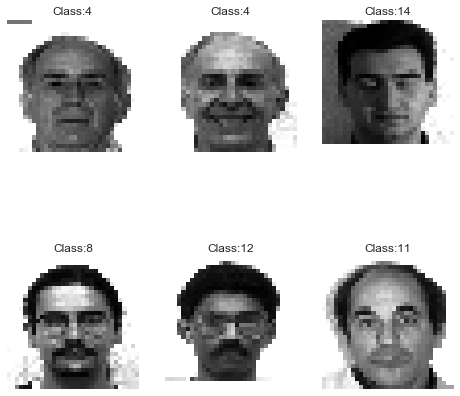

In [138]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
print('ind is ', ind)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [169]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))
print(X.shape)

(165, 1024)


###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [140]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k, pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [141]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    print('Xk', X_k.shape)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [142]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [143]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [144]:
def get_vgg_features(dirpath):
    print('dirpath', dirpath)
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [145]:
def get_resnet_features(dirpath):
    print('resnet features dirpath', dirpath)
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________
The eigenvectors which we derive from the covariance matrix of faces, and then those eigenvectors are called as eigenfaces. And any face is then some linear combination of those eigen faces. Eigen faces are blurry depiction of faces, each one highlighting certain type of features.


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [170]:
# Compute your features 
# eg.
# X_3D = get_kernel_lda(X,y,3)
X_3D ,pca= get_pca(X,3)
print('X_3D', X_3D.shape)


X_3D (165, 3)


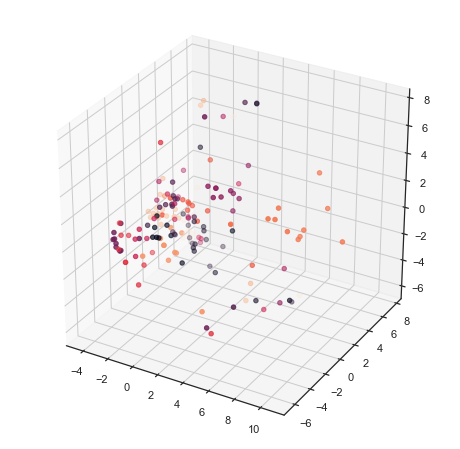

In [147]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)

In [172]:
# Plot the eigen value spectrum 
from numpy import linalg as LA
print(X.shape)
cov = np.cov(X.T) # need to do transpose to use np.cov
eigenvalues, eigenvectors = LA.eigh(cov)
eigenvalues.sort()
eigenvalues = eigenvalues[::-1]
total = sum(eigenvalues)
var_exp = eigenvalues/total
xaxis = np.arange(1000)
# plt.bar(xaxis, var_exp[:1000])
# plt.title('Yale Eigen Spectrum')
# plt.tight_layout()
# plt.savefig('Yale Eigen Spectrum.png', dpi=300)
# plt.show()


(165, 1024)


1(c). Reconstruct  the  image  back for each case


In [149]:
def reconstruct_images(noOfComponents = 20):    
    transformed,pca = get_pca(X,noOfComponents)
    reconstructed = pca.inverse_transform(transformed)
    return reconstructed


Reconstruction Error
0.1269606626432526
disply_images


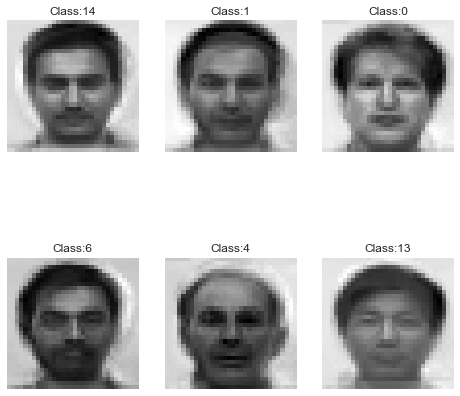

In [150]:
#### Display results 
if(dirpath == './dataset/IMFDB/' ):
    nComponents = 20
    titleOfGraph = 'Reconstruction For IMFDB'
elif(dirpath == './dataset/IIIT-CFW/' ):
    nComponents = 100
    titleOfGraph = 'Reconstruction For IIIT - CFW'
elif(dirpath == './dataset/Yale_face_database/' ):
    nComponents = 10
    titleOfGraph = 'Reconstruction For Yale Face Database'

X_reconstruced = reconstruct_images(nComponents)
# Show the reconstruction error
print('Reconstruction Error')
print(np.sqrt(np.mean((X - X_reconstruced)**2)))
if(opt['is_grayscale']):
    X_reconstruced = X_reconstruced.reshape((N,H,W))
else:
    X_reconstruced = X_reconstruced.reshape((N,H,W,C))


# Display random images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_reconstruced[ind,...],y[ind],titleOfGraph, row=2,col=3)



1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [151]:
# code goes here

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [152]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self):
#         super.__init__()
        self.solver = 'adam'
        self.hidden_layer_sizes = (128,128,128)
        self.activation = 'relu'
        self.max_iter = 2000
        self.verbose = True
        self.tol = 1e-4
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        return self.clf.predict(X)
        
    def confusion_matrix(self,pred,y):
        return confusion_matrix(pred, y)

        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        
    def train(self,X_train,y_train):
        print('training')
        self.clf = MLPClassifier(solver=self.solver,
                        hidden_layer_sizes=self.hidden_layer_sizes,
                        activation=self.activation,
                        max_iter = self.max_iter,
                        verbose=self.verbose,
                        tol=self.tol)
        self.clf.fit(X_train, y_train)        
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        
    def validate(self,X_validate,y_validate):
        y_test = self.classify(X_validate)
        # Create a confusion matrix
        confusionmatrix = confusion_matrix(y_test,y_validate)
#         print('confusionmatrix',confusionmatrix)
        # Calculate Validation accuracy 
        accurarcy =  accuracy_score(y_test, y_validate)
        print('accuracy',accurarcy)
        # Calculate precision and recall 
        precisionscore = precision_score(y_validate,y_test,average='micro')
        print('precision score',precisionscore )
        recallscore = recall_score(y_validate,y_test, average='micro')
        print('recall score', recallscore)
        # Calculate F1-score
        f1score = f1_score(y_validate,y_test,average='micro')
        print('F1 Score', f1score)

        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """

        return confusionmatrix, accurarcy, precisionscore, recallscore, f1score

In [153]:
# Create a train and validation split to train your classifier 

X_reconstruced_flatten = X_reconstruced.reshape((N,H*W*C))
print('X_reconstruced',X_reconstruced_flatten.shape)
X_train, X_test, y_train, y_test = train_test_split( X_reconstruced_flatten, y, test_size=0.25, random_state=42)

classifier = Classifier()
classifier.train(X_train,y_train)
classifier.validate(X_test,y_test)


X_reconstruced (165, 1024)
training
Iteration 1, loss = 2.87648234
Iteration 2, loss = 2.71505364
Iteration 3, loss = 2.62236294
Iteration 4, loss = 2.56611963
Iteration 5, loss = 2.48754781
Iteration 6, loss = 2.40354665
Iteration 7, loss = 2.32421178
Iteration 8, loss = 2.23304713
Iteration 9, loss = 2.14748302
Iteration 10, loss = 2.04844218
Iteration 11, loss = 1.94363360
Iteration 12, loss = 1.83806128
Iteration 13, loss = 1.73005666
Iteration 14, loss = 1.62354410
Iteration 15, loss = 1.51050459
Iteration 16, loss = 1.39966969
Iteration 17, loss = 1.28546039
Iteration 18, loss = 1.17507088
Iteration 19, loss = 1.07185232
Iteration 20, loss = 0.96971086
Iteration 21, loss = 0.87395239
Iteration 22, loss = 0.78369040
Iteration 23, loss = 0.70321421
Iteration 24, loss = 0.62928334
Iteration 25, loss = 0.56241764
Iteration 26, loss = 0.50134685
Iteration 27, loss = 0.44698137
Iteration 28, loss = 0.39784499
Iteration 29, loss = 0.35303270
Iteration 30, loss = 0.31334501
Iteration 31,

(array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]], dtype=int64),
 0.8809523809523809,
 0.8809523809523809,
 0.8809523809523809,
 0.8809523809523809)

In [154]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

def generateTableComparingFeaturesForADataSet(noOfComponent_dict,_dirpath, title = 'test table.png'):
    classifier = Classifier()
    if (_dirpath == './dataset/Yale_face_database/' ):
        C = 1
        opt['is_grayscale']=True
    else:
        C = 3
        opt['is_grayscale']=False
    print('Fetching data...')
    X,y = load_data(_dirpath)
    print('Shape of X', X.shape)
    N,H,W = X.shape[0:3]
    X = X.reshape((N,H*W*C))
    ## PCA Features......
    pca_features, pca = get_pca(X,noOfComponent_dict['Eigen Face'])
    kernel_pca = get_kernel_pca(X,noOfComponent_dict['Kernel PCA'])
    fisher_face= get_lda(X,y,noOfComponent_dict['Fisher Face'])
    kernel_lda = get_kernel_lda(X,y,noOfComponent_dict['Kernel LDA'])
    vgg_features = get_vgg_features(_dirpath)
    resnet_features = get_resnet_features(_dirpath)
    
    features_dict = {
        'Eigen Face' : pca_features,
        'Kernel PCA' : kernel_pca,
        'Fisher Face' : fisher_face,
        'Kernel LDA' : kernel_lda,
        'VGG' : vgg_features,
        'resnet' : resnet_features
    }
    
    dataset_comparision_table = []
    
    for feature_method in features_dict: 
        print('feature method...  ',feature_method )
        features = features_dict[feature_method]
        print('feature shape', features.shape)
        if(feature_method  == 'VGG' or feature_method == 'resnet'):
            noOfComponent_dict[feature_method] = features.shape[1]
            print('Entering no of component')
        X_train, X_test, y_train, y_test = train_test_split( features, y, test_size=0.25, random_state=42)
        classifier.train(X_train,y_train)
        confusionmatrix, accurarcy, precisionscore, recallscore, f1score = classifier.validate(X_test,y_test)
        row = np.array([ '{} & MLP'.format(feature_method) ,noOfComponent_dict[feature_method] , 1-accurarcy , accurarcy, f1score ])
        print('Row..', row)
        dataset_comparision_table.append(row)
    dataset_comparision_table = np.array(dataset_comparision_table)
    print('dataset comparision', dataset_comparision_table)
    
    
    df = pd.DataFrame(dataset_comparision_table,columns=['Combination of feature used','reduced dimension space','classification error','accuracy','f1-score'])
    print(df)
    # set fig size
    fig, ax = plt.subplots(figsize=(12, 3)) 
    # no axes
    ax.xaxis.set_visible(False)  
    ax.yaxis.set_visible(False)  
    # no frame
    ax.set_frame_on(False)  
    # plot table
    tab = table(ax, df, loc='upper right')  
    # set font manually
    tab.auto_set_font_size(False)
    tab.set_fontsize(8) 
    # save the result
    plt.savefig(title,bbox_inches='tight')

    


Fetching data...
load_data calling.. ./dataset/Yale_face_database/
Dataset shape: (165, 32, 32)
Shape of X (165, 32, 32)
Xk (165, 10)


c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


dirpath ./dataset/Yale_face_database/
resnet features dirpath ./dataset/Yale_face_database/
feature method...   Eigen Face
feature shape (165, 10)
training
Iteration 1, loss = 2.82475494
Iteration 2, loss = 2.67608479
Iteration 3, loss = 2.54060243
Iteration 4, loss = 2.41498706
Iteration 5, loss = 2.29671644
Iteration 6, loss = 2.18320798
Iteration 7, loss = 2.07274879
Iteration 8, loss = 1.96521998
Iteration 9, loss = 1.86053809
Iteration 10, loss = 1.75866189
Iteration 11, loss = 1.65820670
Iteration 12, loss = 1.55924053
Iteration 13, loss = 1.46166924
Iteration 14, loss = 1.36609772
Iteration 15, loss = 1.27195432
Iteration 16, loss = 1.17960192
Iteration 17, loss = 1.08905934
Iteration 18, loss = 1.00193754
Iteration 19, loss = 0.91824096
Iteration 20, loss = 0.83865709
Iteration 21, loss = 0.76361081
Iteration 22, loss = 0.69369540
Iteration 23, loss = 0.62881136
Iteration 24, loss = 0.56896325
Iteration 25, loss = 0.51419897
Iteration 26, loss = 0.46411909
Iteration 27, loss = 

Iteration 158, loss = 0.06125642
Iteration 159, loss = 0.05979423
Iteration 160, loss = 0.05837886
Iteration 161, loss = 0.05700808
Iteration 162, loss = 0.05568943
Iteration 163, loss = 0.05441076
Iteration 164, loss = 0.05317379
Iteration 165, loss = 0.05197553
Iteration 166, loss = 0.05081540
Iteration 167, loss = 0.04969266
Iteration 168, loss = 0.04860737
Iteration 169, loss = 0.04755512
Iteration 170, loss = 0.04653585
Iteration 171, loss = 0.04554789
Iteration 172, loss = 0.04459007
Iteration 173, loss = 0.04366338
Iteration 174, loss = 0.04276472
Iteration 175, loss = 0.04189334
Iteration 176, loss = 0.04104756
Iteration 177, loss = 0.04022781
Iteration 178, loss = 0.03943281
Iteration 179, loss = 0.03866069
Iteration 180, loss = 0.03791210
Iteration 181, loss = 0.03718315
Iteration 182, loss = 0.03647658
Iteration 183, loss = 0.03578913
Iteration 184, loss = 0.03512126
Iteration 185, loss = 0.03447036
Iteration 186, loss = 0.03383860
Iteration 187, loss = 0.03322334
Iteration 

Iteration 37, loss = 0.05536809
Iteration 38, loss = 0.05024547
Iteration 39, loss = 0.04579449
Iteration 40, loss = 0.04190549
Iteration 41, loss = 0.03847301
Iteration 42, loss = 0.03543690
Iteration 43, loss = 0.03273174
Iteration 44, loss = 0.03033233
Iteration 45, loss = 0.02819214
Iteration 46, loss = 0.02628197
Iteration 47, loss = 0.02456593
Iteration 48, loss = 0.02304301
Iteration 49, loss = 0.02166980
Iteration 50, loss = 0.02042133
Iteration 51, loss = 0.01929058
Iteration 52, loss = 0.01825564
Iteration 53, loss = 0.01730683
Iteration 54, loss = 0.01643859
Iteration 55, loss = 0.01564045
Iteration 56, loss = 0.01490743
Iteration 57, loss = 0.01423169
Iteration 58, loss = 0.01360547
Iteration 59, loss = 0.01302213
Iteration 60, loss = 0.01248180
Iteration 61, loss = 0.01198043
Iteration 62, loss = 0.01151219
Iteration 63, loss = 0.01107502
Iteration 64, loss = 0.01066680
Iteration 65, loss = 0.01028386
Iteration 66, loss = 0.00992483
Iteration 67, loss = 0.00958613
Iteratio

Iteration 31, loss = 0.00032738
Iteration 32, loss = 0.00031263
Iteration 33, loss = 0.00030084
Iteration 34, loss = 0.00029137
Iteration 35, loss = 0.00028371
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
accuracy 0.9523809523809523
precision score 0.9523809523809523
recall score 0.9523809523809523
F1 Score 0.9523809523809523
Row.. ['resnet & MLP' '2048' '0.04761904761904767' '0.9523809523809523'
 '0.9523809523809523']
dataset comparision [['Eigen Face & MLP' '10' '0.30952380952380953' '0.6904761904761905'
  '0.6904761904761905']
 ['Kernel PCA & MLP' '10' '0.19047619047619047' '0.8095238095238095'
  '0.8095238095238095']
 ['Fisher Face & MLP' '5' '0.023809523809523836' '0.9761904761904762'
  '0.9761904761904762']
 ['Kernel LDA & MLP' '5' '0.023809523809523836' '0.9761904761904762'
  '0.9761904761904762']
 ['VGG & MLP' '4096' '0.4285714285714286' '0.5714285714285714'
  '0.5714285714285714']
 ['resnet & MLP' '2048' '0.04761904761904767' '0.952

c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3072, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.p

dirpath ./dataset/IMFDB/
resnet features dirpath ./dataset/IMFDB/
feature method...   Eigen Face
feature shape (400, 25)
training
Iteration 1, loss = 2.19254985
Iteration 2, loss = 1.93448213
Iteration 3, loss = 1.74144422
Iteration 4, loss = 1.58536233
Iteration 5, loss = 1.45738008
Iteration 6, loss = 1.34981802
Iteration 7, loss = 1.24864561
Iteration 8, loss = 1.15667247
Iteration 9, loss = 1.06701310
Iteration 10, loss = 0.98145309
Iteration 11, loss = 0.90119368
Iteration 12, loss = 0.82929915
Iteration 13, loss = 0.75755938
Iteration 14, loss = 0.69042773
Iteration 15, loss = 0.62491868
Iteration 16, loss = 0.56800037
Iteration 17, loss = 0.51740451
Iteration 18, loss = 0.47084697
Iteration 19, loss = 0.42671540
Iteration 20, loss = 0.38836178
Iteration 21, loss = 0.35188546
Iteration 22, loss = 0.31974052
Iteration 23, loss = 0.28965052
Iteration 24, loss = 0.26233901
Iteration 25, loss = 0.23820386
Iteration 26, loss = 0.21702566
Iteration 27, loss = 0.19794514
Iteration 28, l

Iteration 158, loss = 0.24936123
Iteration 159, loss = 0.24696555
Iteration 160, loss = 0.24717577
Iteration 161, loss = 0.24232615
Iteration 162, loss = 0.24077009
Iteration 163, loss = 0.24032886
Iteration 164, loss = 0.23609483
Iteration 165, loss = 0.23609974
Iteration 166, loss = 0.23140337
Iteration 167, loss = 0.23094684
Iteration 168, loss = 0.22931615
Iteration 169, loss = 0.22550262
Iteration 170, loss = 0.22250849
Iteration 171, loss = 0.22130797
Iteration 172, loss = 0.22118442
Iteration 173, loss = 0.21944141
Iteration 174, loss = 0.21611077
Iteration 175, loss = 0.21437691
Iteration 176, loss = 0.21211229
Iteration 177, loss = 0.21193857
Iteration 178, loss = 0.21073008
Iteration 179, loss = 0.20781720
Iteration 180, loss = 0.20962859
Iteration 181, loss = 0.20666250
Iteration 182, loss = 0.20771952
Iteration 183, loss = 0.20312721
Iteration 184, loss = 0.20001687
Iteration 185, loss = 0.19720766
Iteration 186, loss = 0.19628188
Iteration 187, loss = 0.19366223
Iteration 

Iteration 418, loss = 0.02400994
Iteration 419, loss = 0.02356155
Iteration 420, loss = 0.02336075
Iteration 421, loss = 0.02327626
Iteration 422, loss = 0.02295933
Iteration 423, loss = 0.02278578
Iteration 424, loss = 0.02273400
Iteration 425, loss = 0.02236407
Iteration 426, loss = 0.02204492
Iteration 427, loss = 0.02182915
Iteration 428, loss = 0.02167950
Iteration 429, loss = 0.02154889
Iteration 430, loss = 0.02129845
Iteration 431, loss = 0.02113702
Iteration 432, loss = 0.02106330
Iteration 433, loss = 0.02071394
Iteration 434, loss = 0.02058008
Iteration 435, loss = 0.02039709
Iteration 436, loss = 0.02023955
Iteration 437, loss = 0.02012414
Iteration 438, loss = 0.01994335
Iteration 439, loss = 0.01966305
Iteration 440, loss = 0.01965934
Iteration 441, loss = 0.01933338
Iteration 442, loss = 0.01929485
Iteration 443, loss = 0.01929410
Iteration 444, loss = 0.01909543
Iteration 445, loss = 0.01876611
Iteration 446, loss = 0.01869983
Iteration 447, loss = 0.01868198
Iteration 

Iteration 32, loss = 0.01472931
Iteration 33, loss = 0.01403741
Iteration 34, loss = 0.01323580
Iteration 35, loss = 0.01247895
Iteration 36, loss = 0.01181538
Iteration 37, loss = 0.01111404
Iteration 38, loss = 0.01070548
Iteration 39, loss = 0.01010102
Iteration 40, loss = 0.00952723
Iteration 41, loss = 0.00914175
Iteration 42, loss = 0.00863743
Iteration 43, loss = 0.00836433
Iteration 44, loss = 0.00803362
Iteration 45, loss = 0.00775333
Iteration 46, loss = 0.00734346
Iteration 47, loss = 0.00699972
Iteration 48, loss = 0.00666789
Iteration 49, loss = 0.00640115
Iteration 50, loss = 0.00614916
Iteration 51, loss = 0.00592396
Iteration 52, loss = 0.00565745
Iteration 53, loss = 0.00545374
Iteration 54, loss = 0.00525906
Iteration 55, loss = 0.00503706
Iteration 56, loss = 0.00485876
Iteration 57, loss = 0.00465531
Iteration 58, loss = 0.00449310
Iteration 59, loss = 0.00432492
Iteration 60, loss = 0.00417304
Iteration 61, loss = 0.00401275
Iteration 62, loss = 0.00385352
Iteratio

Fetching data...
load_data calling.. ./dataset/IIIT-CFW/
Dataset shape: (672, 32, 32, 3)
Shape of X (672, 32, 32, 3)
Xk (672, 40)


c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3072, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.p

dirpath ./dataset/IIIT-CFW/
resnet features dirpath ./dataset/IIIT-CFW/
feature method...   Eigen Face
feature shape (672, 40)
training
Iteration 1, loss = 2.22153740
Iteration 2, loss = 1.92016894
Iteration 3, loss = 1.72449417
Iteration 4, loss = 1.58268230
Iteration 5, loss = 1.44750616
Iteration 6, loss = 1.33115428
Iteration 7, loss = 1.21824600
Iteration 8, loss = 1.12010545
Iteration 9, loss = 1.02292796
Iteration 10, loss = 0.94122229
Iteration 11, loss = 0.86528412
Iteration 12, loss = 0.80428581
Iteration 13, loss = 0.73815339
Iteration 14, loss = 0.68730525
Iteration 15, loss = 0.63172392
Iteration 16, loss = 0.58700940
Iteration 17, loss = 0.54101677
Iteration 18, loss = 0.49797847
Iteration 19, loss = 0.46257539
Iteration 20, loss = 0.42692174
Iteration 21, loss = 0.39269397
Iteration 22, loss = 0.36535763
Iteration 23, loss = 0.33471959
Iteration 24, loss = 0.30690313
Iteration 25, loss = 0.28131427
Iteration 26, loss = 0.25764345
Iteration 27, loss = 0.23938194
Iteration

Iteration 117, loss = 0.54682985
Iteration 118, loss = 0.54524389
Iteration 119, loss = 0.53732581
Iteration 120, loss = 0.53311221
Iteration 121, loss = 0.52889744
Iteration 122, loss = 0.52759721
Iteration 123, loss = 0.52265569
Iteration 124, loss = 0.51405033
Iteration 125, loss = 0.51060821
Iteration 126, loss = 0.50902258
Iteration 127, loss = 0.50021872
Iteration 128, loss = 0.49828753
Iteration 129, loss = 0.49446062
Iteration 130, loss = 0.49259381
Iteration 131, loss = 0.48596043
Iteration 132, loss = 0.48084161
Iteration 133, loss = 0.47606692
Iteration 134, loss = 0.47214360
Iteration 135, loss = 0.47000953
Iteration 136, loss = 0.46661072
Iteration 137, loss = 0.45971791
Iteration 138, loss = 0.45818578
Iteration 139, loss = 0.45172725
Iteration 140, loss = 0.44919742
Iteration 141, loss = 0.44773897
Iteration 142, loss = 0.44241214
Iteration 143, loss = 0.44088617
Iteration 144, loss = 0.43517216
Iteration 145, loss = 0.42818302
Iteration 146, loss = 0.42661314
Iteration 

Iteration 372, loss = 0.02663202
Iteration 373, loss = 0.02614443
Iteration 374, loss = 0.02539099
Iteration 375, loss = 0.02540087
Iteration 376, loss = 0.02555508
Iteration 377, loss = 0.02467561
Iteration 378, loss = 0.02448708
Iteration 379, loss = 0.02411715
Iteration 380, loss = 0.02374994
Iteration 381, loss = 0.02349942
Iteration 382, loss = 0.02364938
Iteration 383, loss = 0.02282140
Iteration 384, loss = 0.02276268
Iteration 385, loss = 0.02232647
Iteration 386, loss = 0.02212885
Iteration 387, loss = 0.02171335
Iteration 388, loss = 0.02135687
Iteration 389, loss = 0.02127052
Iteration 390, loss = 0.02089893
Iteration 391, loss = 0.02082528
Iteration 392, loss = 0.02076306
Iteration 393, loss = 0.02051369
Iteration 394, loss = 0.02013374
Iteration 395, loss = 0.01976617
Iteration 396, loss = 0.01996299
Iteration 397, loss = 0.01915415
Iteration 398, loss = 0.01899222
Iteration 399, loss = 0.01894575
Iteration 400, loss = 0.01862627
Iteration 401, loss = 0.01860286
Iteration 

Iteration 6, loss = 0.31507900
Iteration 7, loss = 0.21239078
Iteration 8, loss = 0.15489218
Iteration 9, loss = 0.12307925
Iteration 10, loss = 0.10517907
Iteration 11, loss = 0.09392794
Iteration 12, loss = 0.08516667
Iteration 13, loss = 0.07742888
Iteration 14, loss = 0.07154096
Iteration 15, loss = 0.06569731
Iteration 16, loss = 0.06170013
Iteration 17, loss = 0.05652278
Iteration 18, loss = 0.05291266
Iteration 19, loss = 0.04919357
Iteration 20, loss = 0.04591559
Iteration 21, loss = 0.04348647
Iteration 22, loss = 0.04018922
Iteration 23, loss = 0.03815192
Iteration 24, loss = 0.03557115
Iteration 25, loss = 0.03346447
Iteration 26, loss = 0.03132033
Iteration 27, loss = 0.02958066
Iteration 28, loss = 0.02794027
Iteration 29, loss = 0.02651869
Iteration 30, loss = 0.02506430
Iteration 31, loss = 0.02404826
Iteration 32, loss = 0.02261997
Iteration 33, loss = 0.02157704
Iteration 34, loss = 0.02030272
Iteration 35, loss = 0.01911140
Iteration 36, loss = 0.01837828
Iteration 37

Iteration 160, loss = 0.15349815
Iteration 161, loss = 0.16628077
Iteration 162, loss = 0.15747388
Iteration 163, loss = 0.15616995
Iteration 164, loss = 0.14905298
Iteration 165, loss = 0.15386612
Iteration 166, loss = 0.15951172
Iteration 167, loss = 0.16685761
Iteration 168, loss = 0.15863796
Iteration 169, loss = 0.15374012
Iteration 170, loss = 0.16869398
Iteration 171, loss = 0.15272764
Iteration 172, loss = 0.15351896
Iteration 173, loss = 0.14702634
Iteration 174, loss = 0.15775957
Iteration 175, loss = 0.15736154
Iteration 176, loss = 0.14007864
Iteration 177, loss = 0.13460906
Iteration 178, loss = 0.13233745
Iteration 179, loss = 0.14926273
Iteration 180, loss = 0.12982016
Iteration 181, loss = 0.13881402
Iteration 182, loss = 0.14847452
Iteration 183, loss = 0.14021730
Iteration 184, loss = 0.12818428
Iteration 185, loss = 0.13561328
Iteration 186, loss = 0.13658684
Iteration 187, loss = 0.12807152
Iteration 188, loss = 0.12789077
Iteration 189, loss = 0.12246337
Iteration 

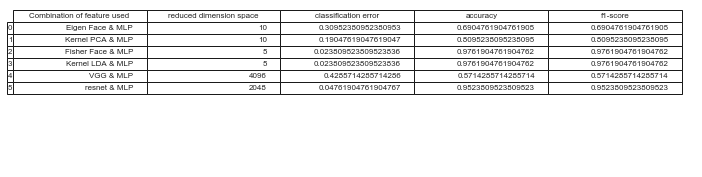

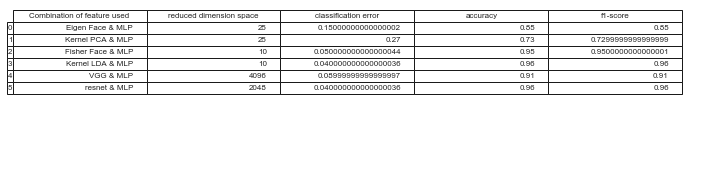

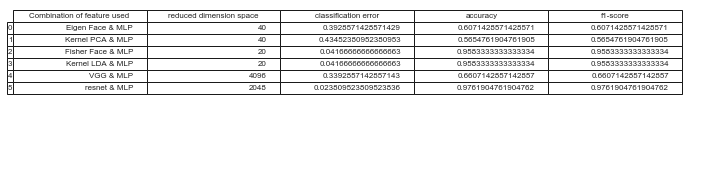

In [155]:
# For each dataset print the confusion matrix for the best model 

yale_component_dict = {
        'Eigen Face' : 10,
        'Kernel PCA' : 10,
        'Fisher Face' : 5,
        'Kernel LDA' : 5,
    }
generateTableComparingFeaturesForADataSet(yale_component_dict,'./dataset/Yale_face_database/', 'Yale Face Comparision.png')

imfdb_component_dict = {
        'Eigen Face' : 25,
        'Kernel PCA' : 25,
        'Fisher Face' : 10,
        'Kernel LDA' : 10,
    }
generateTableComparingFeaturesForADataSet(imfdb_component_dict,'./dataset/IMFDB/', 'IMFDB Face Comparision.png')

iiitcfw_component_dict = {
        'Eigen Face' : 40,
        'Kernel PCA' : 40,
        'Fisher Face' : 20,
        'Kernel LDA' : 20,
    }
generateTableComparingFeaturesForADataSet(iiitcfw_component_dict,'./dataset/IIIT-CFW/', 'IIIT-CFW Face Comparision.png')



3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

len 40
load_data calling.. ./dataset/Yale_face_database/
Dataset shape: (165, 32, 32)
new y;;;;;;; range(0, 15)
y length [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
y  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
(165, 1024)
(165,)


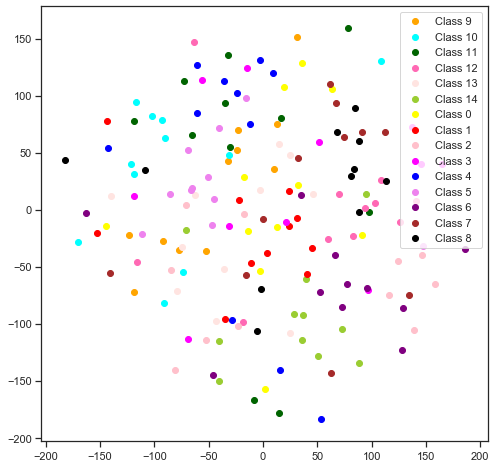

load_data calling.. ./dataset/Yale_face_database/
Dataset shape: (165, 32, 32)
new y;;;;;;; range(0, 15)
y length [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
y  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
(165, 1024)
(165,)


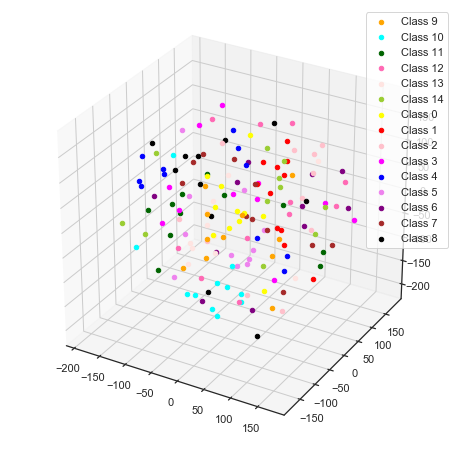

load_data calling.. ./dataset/IMFDB/
Dataset shape: (400, 32, 32)
new y;;;;;;; range(0, 8)
y length [0 1 2 3 4 5 6 7]
y  [0. 1. 2. 3. 4. 5. 6. 7.]
(400, 1024)
(400,)


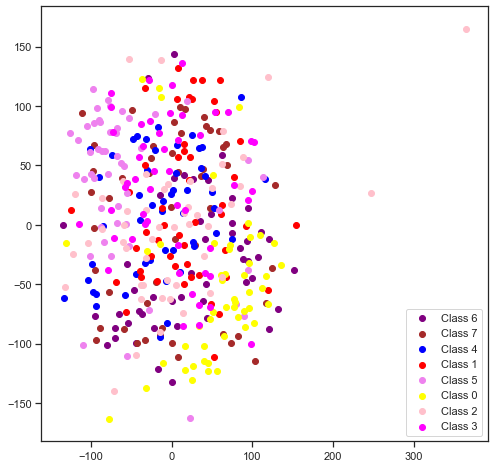

load_data calling.. ./dataset/IMFDB/
Dataset shape: (400, 32, 32)
new y;;;;;;; range(0, 8)
y length [0 1 2 3 4 5 6 7]
y  [0. 1. 2. 3. 4. 5. 6. 7.]
(400, 1024)
(400,)


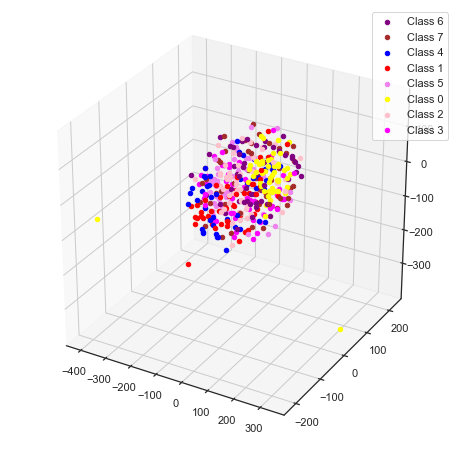

load_data calling.. ./dataset/IIIT-CFW/
Dataset shape: (672, 32, 32)
new y;;;;;;; range(0, 8)
y length [0 1 2 3 4 5 6 7]
y  [0. 1. 2. 3. 4. 5. 6. 7.]
(672, 1024)
(672,)


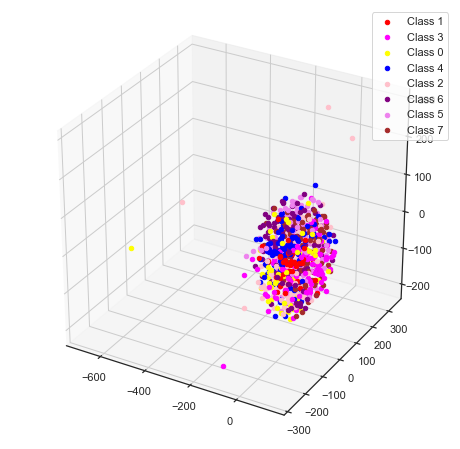

load_data calling.. ./dataset/IIIT-CFW/
Dataset shape: (672, 32, 32)
new y;;;;;;; range(0, 8)
y length [0 1 2 3 4 5 6 7]
y  [0. 1. 2. 3. 4. 5. 6. 7.]
(672, 1024)
(672,)


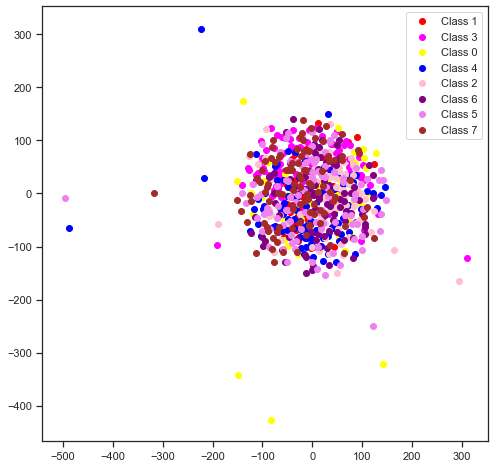

load_data calling.. ./dataset/Yale_face_database/
Dataset shape: (165, 32, 32)
new y;;;;;;; range(0, 15)
y length [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
y  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
load_data calling.. ./dataset/IMFDB/
Dataset shape: (400, 32, 32)
new y;;;;;;; range(15, 23)
y length [15 16 17 18 19 20 21 22]
y  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22.]
load_data calling.. ./dataset/IIIT-CFW/
Dataset shape: (672, 32, 32)
new y;;;;;;; range(23, 31)
y length [23 24 25 26 27 28 29 30]
y  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
(1237, 1024)
(1237,)


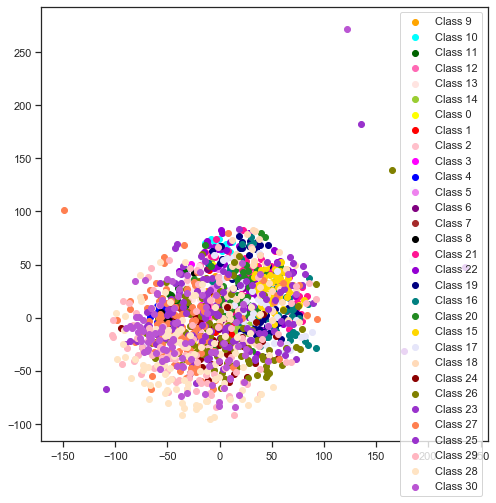

load_data calling.. ./dataset/Yale_face_database/
Dataset shape: (165, 32, 32)
new y;;;;;;; range(0, 15)
y length [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
y  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
load_data calling.. ./dataset/IMFDB/
Dataset shape: (400, 32, 32)
new y;;;;;;; range(15, 23)
y length [15 16 17 18 19 20 21 22]
y  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22.]
load_data calling.. ./dataset/IIIT-CFW/
Dataset shape: (672, 32, 32)
new y;;;;;;; range(23, 31)
y length [23 24 25 26 27 28 29 30]
y  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
(1237, 1024)
(1237,)


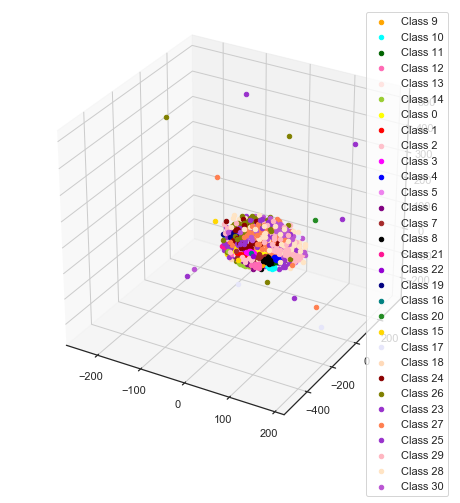

In [156]:
# Compute TSNE for different features and create a scatter plot
from collections import OrderedDict
colors = ['yellow', 'red', 'pink', 'magenta', 'blue', 'violet', 'purple',
 'brown', 'black', 'orange', 'cyan', 'darkgreen', 'hotpink', 'mistyrose', 
 'yellowgreen', 'gold', 'teal', 'lavender', 'peachpuff', 'navy', 'forestgreen', 
 'deeppink', 'darkviolet', 'darkorchid', 'darkred', 'darkorchid', 'olive', 'coral',
 '#FFE4C4', '#FFB6C1', '#BA55D3', '#4169E1', 'chocolate', '#4B0082', '#DA70D6',
 '#7CFC00', '#00FF7F', '#ADFF2F', '#2E8B57', '#FF0000']

print('len', len(colors))
def getX_TSNE(_dirpaths, n_components, title='testSNE.png'):
    C = 1
    overall_X  = np.empty(shape=[0, 1024])
    overall_Y = np.array([])
    opt['is_grayscale']=True
    
    for _dirpath in _dirpaths:
        X,y = load_data(_dirpath)
        uniqueY = np.unique(y)
        uniqueOverallY = np.unique(overall_Y)
        newY = range(len(uniqueOverallY), len(uniqueOverallY)+len(uniqueY))
        print('new y;;;;;;;', newY)
        for index in range(len(newY)):
            y[y==index]= newY[index]
        print('y length', np.unique(y))
        N,H,W = X.shape[0:3]
        X = X.reshape((N,H*W*C))
        overall_X = np.append(overall_X, X, axis=0)
        overall_Y = np.append(overall_Y, y, axis=0)
        print('y ', np.unique(overall_Y))
    
    X = overall_X
    y = overall_Y.astype(int)
        
    print(X.shape)
    print(y.shape)

    X_TSNE = TSNE(n_components=k).fit_transform(X)
    # Plot the representation in 2d/3d
    fig = plt.figure(figsize=(8,8))
    if(n_components == 2):
        for x_arr, y_arr in zip(X_TSNE,y):
            plt.scatter(x_arr[0],x_arr[1], color = colors[y_arr], label='Class {}'.format(y_arr))

        #         ax = fig.add_subplot(111)
    elif(n_components == 3):
        ax = fig.add_subplot(111, projection='3d')
        for x_arr, y_arr in zip(X_TSNE,y):
            ax.scatter(x_arr[0],x_arr[1],x_arr[2], color = colors[y_arr], label='Class {}'.format(y_arr))


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.savefig(title,bbox_inches='tight')
    plt.show()

getX_TSNE(['./dataset/Yale_face_database/'],2, 'Yale Database with 2 Components') 
getX_TSNE(['./dataset/Yale_face_database/'],3, 'Yale Database with 3 Components') 
getX_TSNE(['./dataset/IMFDB/'],2, 'IMFDB Database with 2 Components') 
getX_TSNE(['./dataset/IMFDB/'],3, 'IMFDB Database with 3 Components') 
getX_TSNE(['./dataset/IIIT-CFW/'],3, 'IIIT-CFW Database with 3 Components') 
getX_TSNE(['./dataset/IIIT-CFW/'],2, 'IIIT-CFW Database with 2 Components') 
getX_TSNE(['./dataset/Yale_face_database/','./dataset/IMFDB/','./dataset/IIIT-CFW/'],2, 'Combined Database with 2 Components') 
getX_TSNE(['./dataset/Yale_face_database/','./dataset/IMFDB/','./dataset/IIIT-CFW/'],3, 'Combined Database with 3 Components') 


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [157]:
class FaceVerification():
    def __init__(self):
        self.n_neighbors = 5
       # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        predict_class_id = neigh.predict(X)
        print('predict_class_id...',predict_class_id)
        verfication_results = (predict_class_id == class_id )
        print('verfication_results...',verfication_results)
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        
        return verfication_results
        
    def train(self,X_train,y_train):
         self.neigh = KNeighborsClassifier(n_neighbors=self.n_neighbors)
         self.neigh.fit(X_train, y_train) 
         """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
    
    def validate(self,X_validate,y_validate):
        y_test = self.neigh.predict(X_validate)
        # Create a confusion matrix
        confusionmatrix = confusion_matrix(y_test,y_validate)
#         print('confusionmatrix',confusionmatrix)
        # Calculate Validation accuracy 
        accurarcy =  accuracy_score(y_test, y_validate)
        print('accuracy',accurarcy)
        # Calculate precision and recall 
        precisionscore = precision_score(y_validate,y_test,average='micro')
        print('precision score',precisionscore )
        recallscore = recall_score(y_validate,y_test, average='micro')
        print('recall score', recallscore)
        # Calculate F1-score
        f1score = f1_score(y_validate,y_test,average='micro')
        print('F1 Score', f1score)
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        return confusionmatrix, accurarcy, precisionscore, recallscore, f1score

In [158]:
# Create a train and validation split and show your results 
X_reconstruced_flatten = X_reconstruced.reshape((N,H*W*C))
print('X_reconstruced',X_reconstruced_flatten.shape)
X_train, X_test, y_train, y_test = train_test_split( X_reconstruced_flatten, y, test_size=0.25, random_state=42)

faceverify = FaceVerification()
faceverify.train(X_train,y_train)
faceverify.validate(X_test,y_test)



def generateTableComparingFeaturesForADataSet(noOfComponent_dict,_dirpath, title = 'test table.png'):
    faceverify = FaceVerification()
    if (_dirpath == './dataset/Yale_face_database/' ):
        C = 1
        opt['is_grayscale']=True
    else:
        C = 3
        opt['is_grayscale']=False
    print('Fetching data...')
    X,y = load_data(_dirpath)
    print('Shape of X', X.shape)
    N,H,W = X.shape[0:3]
    X = X.reshape((N,H*W*C))
    ## PCA Features......
    pca_features, pca = get_pca(X,noOfComponent_dict['Eigen Face'])
    kernel_pca = get_kernel_pca(X,noOfComponent_dict['Kernel PCA'])
    fisher_face= get_lda(X,y,noOfComponent_dict['Fisher Face'])
    kernel_lda = get_kernel_lda(X,y,noOfComponent_dict['Kernel LDA'])
    vgg_features = get_vgg_features(_dirpath)
    resnet_features = get_resnet_features(_dirpath)
    
    features_dict = {
        'Eigen Face' : pca_features,
        'Kernel PCA' : kernel_pca,
        'Fisher Face' : fisher_face,
        'Kernel LDA' : kernel_lda,
        'VGG' : vgg_features,
        'resnet' : resnet_features
    }
    
    dataset_comparision_table = []
    
    for feature_method in features_dict: 
        print('feature method...  ',feature_method )
        features = features_dict[feature_method]
        print('feature shape', features.shape)
        if(feature_method  == 'VGG' or feature_method == 'resnet'):
            noOfComponent_dict[feature_method] = features.shape[1]
            print('Entering no of component')
        X_train, X_test, y_train, y_test = train_test_split( features, y, test_size=0.25, random_state=42)
        faceverify.train(X_train,y_train)
        confusionmatrix, accurarcy, precisionscore, recallscore, f1score = faceverify.validate(X_test,y_test)
        row = np.array([ '{} & MLP'.format(feature_method) ,noOfComponent_dict[feature_method] , 1-accurarcy , accurarcy, f1score ])
        print('Row..', row)
        dataset_comparision_table.append(row)
    dataset_comparision_table = np.array(dataset_comparision_table)
    print('dataset comparision', dataset_comparision_table)
    
    
    df = pd.DataFrame(dataset_comparision_table,columns=['Combination of feature used','reduced dimension space','verification error','accuracy','f1-score'])
    print(df)
    # set fig size
    fig, ax = plt.subplots(figsize=(12, 3)) 
    # no axes
    ax.xaxis.set_visible(False)  
    ax.yaxis.set_visible(False)  
    # no frame
    ax.set_frame_on(False)  
    # plot table
    tab = table(ax, df, loc='upper right')  
    # set font manually
    tab.auto_set_font_size(False)
    tab.set_fontsize(8) 
    # save the result
    plt.savefig(title)



X_reconstruced (165, 1024)
accuracy 0.7380952380952381
precision score 0.7380952380952381
recall score 0.7380952380952381
F1 Score 0.7380952380952381


Fetching data...
load_data calling.. ./dataset/Yale_face_database/
Dataset shape: (165, 32, 32)
Shape of X (165, 32, 32)
Xk (165, 10)


c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


dirpath ./dataset/Yale_face_database/
resnet features dirpath ./dataset/Yale_face_database/
feature method...   Eigen Face
feature shape (165, 10)
accuracy 0.7380952380952381
precision score 0.7380952380952381
recall score 0.7380952380952381
F1 Score 0.7380952380952381
Row.. ['Eigen Face & MLP' '10' '0.26190476190476186' '0.7380952380952381'
 '0.7380952380952381']
feature method...   Kernel PCA
feature shape (165, 10)
accuracy 0.7142857142857143
precision score 0.7142857142857143
recall score 0.7142857142857143
F1 Score 0.7142857142857143
Row.. ['Kernel PCA & MLP' '10' '0.2857142857142857' '0.7142857142857143'
 '0.7142857142857143']
feature method...   Fisher Face
feature shape (165, 5)
accuracy 0.9761904761904762
precision score 0.9761904761904762
recall score 0.9761904761904762
F1 Score 0.9761904761904762
Row.. ['Fisher Face & MLP' '5' '0.023809523809523836' '0.9761904761904762'
 '0.9761904761904762']
feature method...   Kernel LDA
feature shape (165, 5)
accuracy 0.9761904761904762
p

c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3072, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.p

dirpath ./dataset/IMFDB/
resnet features dirpath ./dataset/IMFDB/
feature method...   Eigen Face
feature shape (400, 25)
accuracy 0.67
precision score 0.67
recall score 0.67
F1 Score 0.67
Row.. ['Eigen Face & MLP' '25' '0.32999999999999996' '0.67' '0.67']
feature method...   Kernel PCA
feature shape (400, 25)
accuracy 0.62
precision score 0.62
recall score 0.62
F1 Score 0.62
Row.. ['Kernel PCA & MLP' '25' '0.38' '0.62' '0.62']
feature method...   Fisher Face
feature shape (400, 7)
accuracy 0.97
precision score 0.97
recall score 0.97
F1 Score 0.97
Row.. ['Fisher Face & MLP' '10' '0.030000000000000027' '0.97' '0.97']
feature method...   Kernel LDA
feature shape (400, 7)
accuracy 0.97
precision score 0.97
recall score 0.97
F1 Score 0.97
Row.. ['Kernel LDA & MLP' '10' '0.030000000000000027' '0.97' '0.97']
feature method...   VGG
feature shape (400, 4096)
Entering no of component
accuracy 0.91
precision score 0.91
recall score 0.91
F1 Score 0.91
Row.. ['VGG & MLP' '4096' '0.0899999999999999

c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3072, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.p

dirpath ./dataset/IIIT-CFW/
resnet features dirpath ./dataset/IIIT-CFW/
feature method...   Eigen Face
feature shape (672, 40)
accuracy 0.5178571428571429
precision score 0.5178571428571429
recall score 0.5178571428571429
F1 Score 0.5178571428571429
Row.. ['Eigen Face & MLP' '40' '0.4821428571428571' '0.5178571428571429'
 '0.5178571428571429']
feature method...   Kernel PCA
feature shape (672, 40)
accuracy 0.5178571428571429
precision score 0.5178571428571429
recall score 0.5178571428571429
F1 Score 0.5178571428571429
Row.. ['Kernel PCA & MLP' '40' '0.4821428571428571' '0.5178571428571429'
 '0.5178571428571429']
feature method...   Fisher Face
feature shape (672, 7)
accuracy 0.9583333333333334
precision score 0.9583333333333334
recall score 0.9583333333333334
F1 Score 0.9583333333333334
Row.. ['Fisher Face & MLP' '20' '0.04166666666666663' '0.9583333333333334'
 '0.9583333333333334']
feature method...   Kernel LDA
feature shape (672, 7)
accuracy 0.9583333333333334
precision score 0.9583

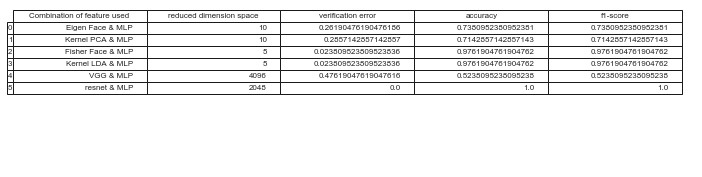

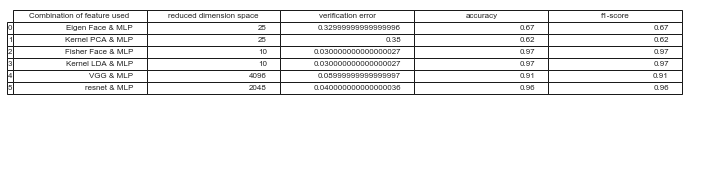

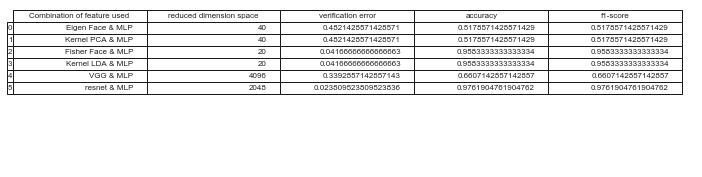

In [159]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)

yale_component_dict = {
        'Eigen Face' : 10,
        'Kernel PCA' : 10,
        'Fisher Face' : 5,
        'Kernel LDA' : 5,
    }
generateTableComparingFeaturesForADataSet(yale_component_dict,'./dataset/Yale_face_database/', 'Yale Face Verification - Comparision.png')

imfdb_component_dict = {
        'Eigen Face' : 25,
        'Kernel PCA' : 25,
        'Fisher Face' : 10,
        'Kernel LDA' : 10,
    }
generateTableComparingFeaturesForADataSet(imfdb_component_dict,'./dataset/IMFDB/', 'IMFDB Face Verification -  Comparision.png')

iiitcfw_component_dict = {
        'Eigen Face' : 40,
        'Kernel PCA' : 40,
        'Fisher Face' : 20,
        'Kernel LDA' : 20,
    }
generateTableComparingFeaturesForADataSet(iiitcfw_component_dict,'./dataset/IIIT-CFW/', 'IIIT-CFW Face Verification -  Comparision.png')

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [160]:
# Load data
# Load the full data from directory
def load_emotion_data(dir_paths):
    image_list = []
    y_list = []
    for dir_path in dir_paths:
        print('dir_path',dir_path)
        for filename in sorted(os.listdir(dir_path)):
            if filename.endswith(".png"):
                im = load_image(os.path.join(dir_path,filename))
                image_list.append(im)
            else:
                continue

        with open(dir_path+'emotion.txt') as f:
            lines = f.readlines()
            lines.sort()
            for i in lines:
                y_list.append(i.split(',')[1])

    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print('image_list', image_list.shape)
    print('y_list', y_list.shape)

    return image_list,y_list


_dirpath = ['./dataset/IMFDB/','./dataset/Yale_face_database/']
opt['is_grayscale']=True
X,y = load_emotion_data(_dirpath)
print(X.shape)
print(y.shape)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
print('C is', C)

X = X.reshape((N,H*W*C))


dir_path ./dataset/IMFDB/
dir_path ./dataset/Yale_face_database/
image_list (565, 32, 32)
y_list (565,)
(565, 32, 32)
(565,)
C is 1


In [161]:
# Define your features
kernel_lda_features = get_kernel_lda(X,y,10)
X_train, X_test, y_train, y_test = train_test_split( kernel_lda_features, y, test_size=0.25, random_state=42)


c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [162]:
# Create your classifier
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Emotion_Classifier():
    def __init__(self):
#         super.__init__()
        self.solver = 'adam'
        self.hidden_layer_sizes = (128,128,128)
        self.activation = 'relu'
        self.max_iter = 2000
        self.verbose = True
        self.tol = 1e-4
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        return self.clf.predict(X)
        
    def confusion_matrix(self,pred,y):
        return confusion_matrix(pred, y)

        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        
    def train(self,X_train,y_train):
        print('training')
        self.clf = MLPClassifier(solver=self.solver,
                        hidden_layer_sizes=self.hidden_layer_sizes,
                        activation=self.activation,
                        max_iter = self.max_iter,
                        verbose=self.verbose,
                        tol=self.tol)
        self.clf.fit(X_train, y_train)        
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        
    def validate(self,X_validate,y_validate):
        y_test = self.classify(X_validate)
        # Create a confusion matrix
        confusionmatrix = confusion_matrix(y_test,y_validate)
#         print('confusionmatrix',confusionmatrix)
        # Calculate Validation accuracy 
        accurarcy =  accuracy_score(y_test, y_validate)
        print('accuracy',accurarcy)
        # Calculate precision and recall 
        precisionscore = precision_score(y_validate,y_test,average='micro')
        print('precision score',precisionscore )
        recallscore = recall_score(y_validate,y_test, average='micro')
        print('recall score', recallscore)
        # Calculate F1-score
        f1score = f1_score(y_validate,y_test,average='micro')
        print('F1 Score', f1score)

        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """

        return confusionmatrix, accurarcy, precisionscore, recallscore, f1score
# Validate your classifier

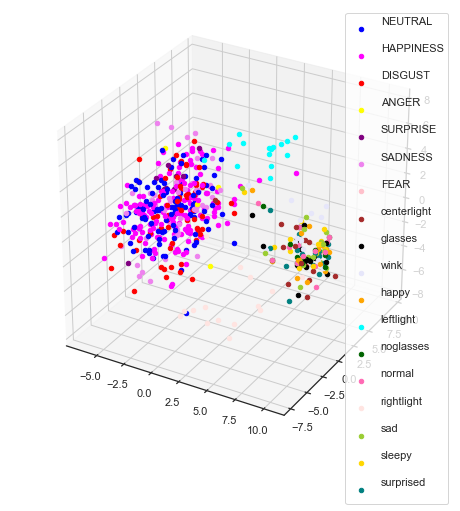

c:\users\shaily mishra\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


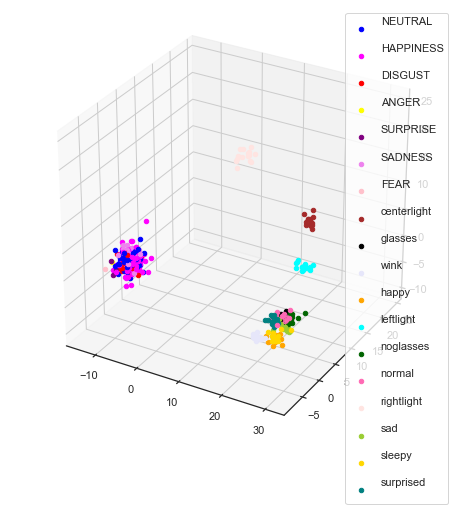

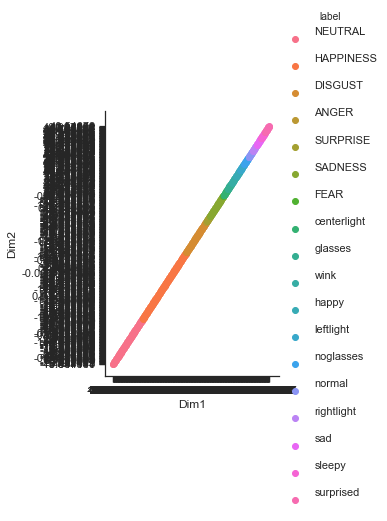

In [163]:

x_pca,pca = get_pca(X,3)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for x_arr, y_arr in zip(x_pca,y):
    ax.scatter(x_arr[0],x_arr[1],x_arr[2], color = colors[labels_color_dict[y_arr]], label='{}'.format(y_arr))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('Scatter_Plot_of_pca.png',bbox_inches='tight')
plt.show()

x_lda = get_lda(X,y,3)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for x_arr, y_arr in zip(x_lda,y):
    ax.scatter(x_arr[0],x_arr[1],x_arr[2], color = colors[labels_color_dict[y_arr]], label='{}'.format(y_arr))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('Scatter_Plot_of_lda.png',bbox_inches='tight')
plt.show()


X_TSNE = TSNE(n_components=2).fit_transform(X)
X_TSNE = np.vstack((X_TSNE.T,y)).T
tsne_df = pd.DataFrame(data=X_TSNE,columns=('Dim1', 'Dim2', 'label'))
import seaborn as sns;
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(tsne_df, hue='label',height=4.5)
g=g.map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()
g.savefig('Emotion_Classification_TSNE.png')
# Plot the representation in 2d/3d


In [164]:
# Show quantitative results such as examples of correct prediction and wrong prediction
classifier = Emotion_Classifier()
classifier.train(X_train,y_train)
classifier.validate(X_test,y_test)


training
Iteration 1, loss = 3.30000037
Iteration 2, loss = 2.21924686
Iteration 3, loss = 1.63187654
Iteration 4, loss = 1.30499836
Iteration 5, loss = 1.10626134
Iteration 6, loss = 0.94787699
Iteration 7, loss = 0.82624985
Iteration 8, loss = 0.75353936
Iteration 9, loss = 0.69431508
Iteration 10, loss = 0.62484682
Iteration 11, loss = 0.56357361
Iteration 12, loss = 0.52522466
Iteration 13, loss = 0.48780371
Iteration 14, loss = 0.45493922
Iteration 15, loss = 0.42968139
Iteration 16, loss = 0.41382604
Iteration 17, loss = 0.40192152
Iteration 18, loss = 0.37877029
Iteration 19, loss = 0.36265321
Iteration 20, loss = 0.35237771
Iteration 21, loss = 0.33420856
Iteration 22, loss = 0.31993279
Iteration 23, loss = 0.30407659
Iteration 24, loss = 0.31273986
Iteration 25, loss = 0.29953170
Iteration 26, loss = 0.29813275
Iteration 27, loss = 0.28833329
Iteration 28, loss = 0.29244525
Iteration 29, loss = 0.27297576
Iteration 30, loss = 0.27088258
Iteration 31, loss = 0.25936350
Iteratio

(array([[ 2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 23,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1, 38,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  2, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  1,  1,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  3,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  